Dataset and assets: https://drive.google.com/drive/folders/1y0ApxlUwMY4zBQAvF-ELJT-7sgjpKTfW?usp=sharing

In [ ]:
# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Prerequisites


## 1.1. Setting up Spark

In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark
!pip install pyspark

In [ ]:
#importing and initializing Spark
import findspark
findspark.init()

In [ ]:
#starting a Spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .config("spark.driver.memory", "15g") \
        .getOrCreate()

In [ ]:
#printing the Spark variable to make sure it works fine
spark

## 1.2. Imports

In [ ]:
# Essentials 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from IPython.display import display
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import networkx as nx
import json
from collections import OrderedDict
import pickle

#spark imports
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans as SKMeans
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.types import *


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#plotting style
sns.set_style("darkgrid")
plt.rcParams['axes.axisbelow'] = True

## 1.3. Constants

In [ ]:
DATA_PATH = '/content/data'

## 1.4. Extraction and Reading of Dataset

In [ ]:
!mkdir data
!cp -r /content/drive/MyDrive/bigdata_project/instacart-market-basket-analysis.zip /content
!unzip -o /content/instacart-market-basket-analysis.zip
!unzip -o /content/aisles.csv.zip -d /content/data
!unzip -o /content/departments.csv.zip -d /content/data
!unzip -o /content/order_products__prior.csv.zip -d /content/data
!unzip -o /content/order_products__train.csv.zip -d /content/data
!unzip -o /content/orders.csv.zip -d /content/data
!unzip -o /content/products.csv.zip -d /content/data


cp: cannot stat '/content/drive/MyDrive/bigdata_project/instacart-market-basket-analysis.zip': No such file or directory
unzip:  cannot find or open /content/instacart-market-basket-analysis.zip, /content/instacart-market-basket-analysis.zip.zip or /content/instacart-market-basket-analysis.zip.ZIP.
unzip:  cannot find or open /content/aisles.csv.zip, /content/aisles.csv.zip.zip or /content/aisles.csv.zip.ZIP.
unzip:  cannot find or open /content/departments.csv.zip, /content/departments.csv.zip.zip or /content/departments.csv.zip.ZIP.
unzip:  cannot find or open /content/order_products__prior.csv.zip, /content/order_products__prior.csv.zip.zip or /content/order_products__prior.csv.zip.ZIP.
unzip:  cannot find or open /content/order_products__train.csv.zip, /content/order_products__train.csv.zip.zip or /content/order_products__train.csv.zip.ZIP.
unzip:  cannot find or open /content/orders.csv.zip, /content/orders.csv.zip.zip or /content/orders.csv.zip.ZIP.
unzip:  cannot find or open /c

In [ ]:
tables=[]

print("=======================Aisles=======================")
aisles = pd.read_csv(f"{DATA_PATH}/aisles.csv", sep=",")
display(aisles.head())
print("Aisles loaded with", len(aisles), "rows")
tables.append(aisles)

print("\n====================Departments=====================")
departments = pd.read_csv(f"{DATA_PATH}/departments.csv", sep=",")
display(departments.head())
print("Departments loaded with", len(departments), "rows")
tables.append(departments)

print("\n=======================Orders=======================")
orders = pd.read_csv(f"{DATA_PATH}/orders.csv", sep=",")
display(orders.head())
print("Orders loaded with", len(orders), "rows")
tables.append(orders)

print("\n====================Products========================")
products = pd.read_csv(f"{DATA_PATH}/products.csv", sep=",")
display(products.head())
print("Products loaded with", len(products), "rows")
tables.append(products)

print("\n================Order Products Prior================")
ordProdPrior = pd.read_csv(f"{DATA_PATH}/order_products__prior.csv", sep=",")
display(ordProdPrior.head())
print("Order Products Prior loaded with", len(ordProdPrior), "rows")
tables.append(ordProdPrior)

print("\n================Order Products Train================")
ordProdTrain = pd.read_csv(f"{DATA_PATH}/order_products__train.csv", sep=",")
display(ordProdTrain.head())
print("Order Products Train loaded with", len(ordProdTrain), "rows")
tables.append(ordProdTrain)

# 3. Preprocessing

## 3.1. Checking for Outliers

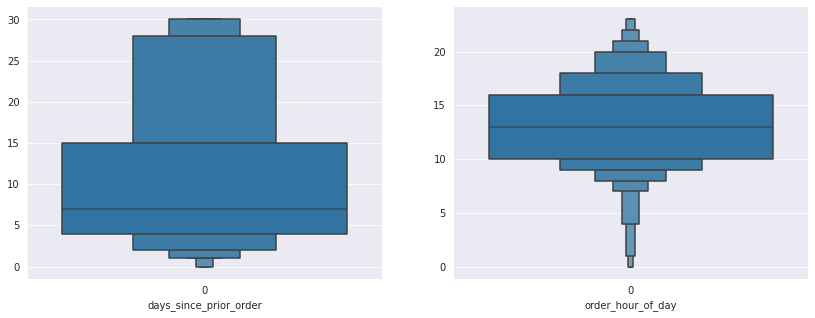

In [ ]:
features = ["days_since_prior_order", "order_hour_of_day"]
fig, axs = plt.subplots(ncols=len(features), figsize=(7*len(features), 5))
for i in range(len(features)):
  sns.boxenplot(data=orders[features[i]],
                showfliers=True,
                ax=axs[i],
                ).set(xlabel=features[i])
  sns.despine()

The data seems to be clear of outliers. Overall, the data is clean and doesn't require preprocessing.

# 4. Feature Engineering


In [ ]:
orders= orders.fillna(-1)
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,-1.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
ordProdPrior = ordProdPrior.merge(orders.drop('eval_set', axis=1), on='order_id')
ordProdTrain = ordProdTrain.merge(orders.drop('eval_set', axis=1), on='order_id')

In [ ]:
user_product_counts = ordProdPrior.groupby(['product_id','user_id'],as_index=False).order_id.count()
user_product_counts

,product_id,user_id,order_id
0,1,138,2
1,1,709,1
2,1,764,2
3,1,777,1
4,1,825,1
...,...,...,...
13307948,49688,197371,1
13307949,49688,200215,1
13307950,49688,200377,1
13307951,49688,200873,2


In [ ]:
train_users = ordProdTrain['user_id'].unique()

In [ ]:
dataset = user_product_counts[user_product_counts['user_id'].isin(train_users)]
dataset.head()

,product_id,user_id,order_id
0,1,138,2
1,1,709,1
3,1,777,1
6,1,1052,2
9,1,1494,3


In [ ]:
dataset.rename(columns={'order_id':'user_product_total_orders'},inplace=True)

In [ ]:
carts = ordProdTrain.groupby('user_id',as_index=False).agg({'product_id':(lambda x: set(x))}).rename(columns={'product_id':'cart'})
carts.head()

,user_id,cart
0,1,"{196, 26405, 27845, 46149, 13032, 39657, 26088..."
1,2,"{24838, 11913, 45066, 31883, 48523, 38547, 248..."
2,5,"{40706, 21413, 20843, 48204, 21616, 19057, 201..."
3,7,"{17638, 29894, 47272, 45066, 13198, 37999, 408..."
4,8,"{27104, 15937, 5539, 41540, 31717, 48230, 2224..."


In [ ]:
dataset['cart'] = carts.set_index('user_id').loc[dataset['user_id']].values
dataset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,product_id,user_id,order_id,cart
0,1,138,2,{42475}
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027..."
3,1,777,1,"{43352, 6184, 16797}"
6,1,1052,2,{17207}
9,1,1494,3,{44560}


In [ ]:
dataset['in_cart'] = dataset.apply(lambda x: x['product_id'] in x['cart'], axis=1).astype(int)
dataset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,product_id,user_id,order_id,cart,in_cart
0,1,138,2,{42475},0
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0
3,1,777,1,"{43352, 6184, 16797}",0
6,1,1052,2,{17207},0
9,1,1494,3,{44560},0


In [ ]:
dataset['in_cart'].value_counts()

0    7645837
1     828824
Name: in_cart, dtype: int64

In [ ]:
product_counts = (ordProdPrior.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
product_counts.head()

,product_id,order_id,add_to_cart_order
0,1,1852,5.801836
1,2,90,9.888889
2,3,277,6.415162
3,4,329,9.507599
4,5,15,6.466667


In [ ]:
product_counts.columns

Index(['product_id', 'product_total_orders', 'product_avg_add_to_cart_order'], dtype='object')

In [ ]:
dataset[['product_total_orders','product_avg_add_to_cart_order']] = product_counts.set_index('product_id').loc[dataset['product_id']].values
dataset.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,product_id,user_id,order_id,cart,in_cart,product_total_orders,product_avg_add_to_cart_order
0,1,138,2,{42475},0,1852.0,5.801836
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852.0,5.801836
3,1,777,1,"{43352, 6184, 16797}",0,1852.0,5.801836
6,1,1052,2,{17207},0,1852.0,5.801836
9,1,1494,3,{44560},0,1852.0,5.801836


In [ ]:
users_counts = (ordProdPrior.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean')])))
users_counts.head()

user_id order_id            product_id days_since_prior_order
           nunique <lambda_0>    nunique                   mean
0       1       10   5.900000         18              18.457627
1       2       14  13.928571        102              14.835897
2       3       12   7.333333         33              10.068182
3       4        5   3.600000         17              11.722222
4       5        4   9.250000         23               9.891892

In [ ]:
users_counts.head()

,user_id,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,1,10,5.900000,18,18.457627
1,2,14,13.928571,102,14.835897
2,3,12,7.333333,33,10.068182
3,4,5,3.600000,17,11.722222
4,5,4,9.250000,23,9.891892


In [ ]:
dataset[['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']] = users_counts.set_index('user_id').loc[dataset['user_id']].values
dataset.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,product_id,user_id,order_id,cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,1,138,2,{42475},0,1852.0,5.801836,32.0,4.625000,55.0,9.783784
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852.0,5.801836,5.0,38.400000,135.0,5.515625
3,1,777,1,"{43352, 6184, 16797}",0,1852.0,5.801836,26.0,4.346154,30.0,12.141593
6,1,1052,2,{17207},0,1852.0,5.801836,20.0,2.400000,24.0,10.666667
9,1,1494,3,{44560},0,1852.0,5.801836,13.0,12.153846,71.0,5.177215


In [ ]:
user_prod_counts = ordProdPrior.groupby(['product_id','user_id'],as_index=False).add_to_cart_order.mean()
user_prod_counts.head()


,product_id,user_id,add_to_cart_order
0,1,138,3.0
1,1,709,20.0
2,1,764,10.5
3,1,777,7.0
4,1,825,2.0


In [ ]:
dataset = dataset.merge(user_prod_counts.rename(columns={'add_to_cart_order':'user_product_avg_add_to_cart_order'}),on=['product_id','user_id']).dropna()
dataset.head()

,product_id,user_id,order_id,cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order
0,1,138,2,{42475},0,1852.0,5.801836,32.0,4.625000,55.0,9.783784,3.000000
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852.0,5.801836,5.0,38.400000,135.0,5.515625,20.000000
2,1,777,1,"{43352, 6184, 16797}",0,1852.0,5.801836,26.0,4.346154,30.0,12.141593,7.000000
3,1,1052,2,{17207},0,1852.0,5.801836,20.0,2.400000,24.0,10.666667,1.500000
4,1,1494,3,{44560},0,1852.0,5.801836,13.0,12.153846,71.0,5.177215,12.666667


In [ ]:
product_counts = (ordProdPrior.groupby(['product_id'], as_index=False)
                                     .agg(OrderedDict(
                                     [('order_dow','mean'),
                                      ('order_hour_of_day', 'mean'),
                                      ('days_since_prior_order', 'mean')])))
product_counts.head()

,product_id,order_dow,order_hour_of_day,days_since_prior_order
0,1,2.776458,13.238121,9.827754
1,2,2.922222,13.277778,10.100000
2,3,2.736462,12.104693,9.855596
3,4,2.683891,13.714286,12.826748
4,5,2.733333,10.666667,11.533333


In [ ]:
dataset[['product_avg_order_dow','product_avg_order_hour_of_day','product_avg_days_since_prior_order']] = product_counts.set_index('product_id').loc[dataset['product_id']].values
dataset.head()

,product_id,user_id,order_id,cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,product_avg_order_dow\t,product_avg_order_hour_of_day,product_avg_days_since_prior_order
0,1,138,2,{42475},0,1852.0,5.801836,32.0,4.625000,55.0,9.783784,3.000000,2.776458,13.238121,9.827754
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852.0,5.801836,5.0,38.400000,135.0,5.515625,20.000000,2.776458,13.238121,9.827754
2,1,777,1,"{43352, 6184, 16797}",0,1852.0,5.801836,26.0,4.346154,30.0,12.141593,7.000000,2.776458,13.238121,9.827754
3,1,1052,2,{17207},0,1852.0,5.801836,20.0,2.400000,24.0,10.666667,1.500000,2.776458,13.238121,9.827754
4,1,1494,3,{44560},0,1852.0,5.801836,13.0,12.153846,71.0,5.177215,12.666667,2.776458,13.238121,9.827754


In [ ]:
user_counts = (ordProdPrior.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_dow','mean'),
                                                    ('order_hour_of_day','mean')])))
user_counts.head()

,user_id,order_dow,order_hour_of_day
0,1,2.644068,10.542373
1,2,2.005128,10.441026
2,3,1.011364,16.352273
3,4,4.722222,13.111111
4,5,1.621622,15.729730


In [ ]:
dataset[['user_avg_order_dow','user_avg_order_hour_of_day']] = user_counts.set_index('user_id').loc[dataset['user_id']].values
dataset.head()

,product_id,user_id,order_id,cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,product_avg_order_dow\t,product_avg_order_hour_of_day,product_avg_days_since_prior_order,user_avg_order_dow,user_avg_order_hour_of_day
0,1,138,2,{42475},0,1852.0,5.801836,32.0,4.625000,55.0,9.783784,3.000000,2.776458,13.238121,9.827754,3.040541,12.689189
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852.0,5.801836,5.0,38.400000,135.0,5.515625,20.000000,2.776458,13.238121,9.827754,1.651042,19.333333
2,1,777,1,"{43352, 6184, 16797}",0,1852.0,5.801836,26.0,4.346154,30.0,12.141593,7.000000,2.776458,13.238121,9.827754,2.938053,11.716814
3,1,1052,2,{17207},0,1852.0,5.801836,20.0,2.400000,24.0,10.666667,1.500000,2.776458,13.238121,9.827754,2.625000,15.145833
4,1,1494,3,{44560},0,1852.0,5.801836,13.0,12.153846,71.0,5.177215,12.666667,2.776458,13.238121,9.827754,2.784810,12.215190


In [ ]:
user_prod_counts = (ordProdPrior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('days_since_prior_order','mean'),
                                                     ('order_dow','mean'),
                                                     ('order_hour_of_day','mean')])))

In [ ]:
user_prod_counts.head()

,product_id,user_id,days_since_prior_order,order_dow,order_hour_of_day
0,1,138,11.5,6.0,14.0
1,1,709,6.0,0.0,21.0
2,1,764,4.0,3.5,15.0
3,1,777,26.0,1.0,7.0
4,1,825,30.0,2.0,14.0


In [ ]:
dataset = dataset.merge(user_prod_counts.rename(columns={'days_since_prior_order':'user_product_avg_days_since_prior_order',
                                                         'order_dow':'user_product_avg_order_dow',
                                                         'order_hour_of_day':'user_product_avg_order_hour_of_day'}),on=['product_id','user_id']).dropna()
dataset.head()

,product_id,user_id,order_id,cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,product_avg_order_dow\t,product_avg_order_hour_of_day,product_avg_days_since_prior_order,user_avg_order_dow,user_avg_order_hour_of_day,user_product_avg_days_since_prior_order,user_product_avg_order_dow,user_product_avg_order_hour_of_day
0,1,138,2,{42475},0,1852.0,5.801836,32.0,4.625000,55.0,9.783784,3.000000,2.776458,13.238121,9.827754,3.040541,12.689189,11.5,6.000000,14.000000
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852.0,5.801836,5.0,38.400000,135.0,5.515625,20.000000,2.776458,13.238121,9.827754,1.651042,19.333333,6.0,0.000000,21.000000
2,1,777,1,"{43352, 6184, 16797}",0,1852.0,5.801836,26.0,4.346154,30.0,12.141593,7.000000,2.776458,13.238121,9.827754,2.938053,11.716814,26.0,1.000000,7.000000
3,1,1052,2,{17207},0,1852.0,5.801836,20.0,2.400000,24.0,10.666667,1.500000,2.776458,13.238121,9.827754,2.625000,15.145833,17.0,1.000000,16.000000
4,1,1494,3,{44560},0,1852.0,5.801836,13.0,12.153846,71.0,5.177215,12.666667,2.776458,13.238121,9.827754,2.784810,12.215190,6.0,3.333333,8.666667


In [ ]:
dataset['user_product_order_freq'] = dataset['user_product_total_orders'] / dataset['user_total_orders'] 


In [ ]:
dataset['product_total_orders_delta_per_user'] = dataset['product_total_orders'] - dataset['user_product_total_orders']

dataset['product_avg_add_to_cart_order_delta_per_user'] = dataset['product_avg_add_to_cart_order'] - \
                                                            dataset['user_product_avg_add_to_cart_order']

dataset['product_avg_order_dow_per_user'] = dataset['product_avg_order_dow'] - dataset['user_product_avg_order_dow']

dataset['product_avg_order_hour_of_day_per_user'] = dataset['product_avg_order_hour_of_day'] - \
                                                            dataset['user_product_avg_order_hour_of_day']

dataset['product_avg_days_since_prior_order_per_user'] = dataset['product_avg_days_since_prior_order'] - \
                                                            dataset['user_product_avg_days_since_prior_order']

In [ ]:
dataset['in_cart'].value_counts()

0    7645837
1     828824
Name: in_cart, dtype: int64

In [ ]:
product_depratment = products.merge(departments, on = 'department_id')[['product_id', 'department']]
product_depratment.head()

,product_id,department
0,1,snacks
1,16,snacks
2,25,snacks
3,32,snacks
4,41,snacks


In [ ]:
product_depratment = product_depratment.set_index('product_id')
product_depratment.head()

,department
product_id,
1,snacks
16,snacks
25,snacks
32,snacks
41,snacks


In [ ]:
dataset.head()

,product_id,user_id,user_product_total_orders,cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,...,user_avg_order_hour_of_day,user_product_avg_days_since_prior_order,user_product_avg_order_dow,user_product_avg_order_hour_of_day,user_product_order_freq,product_total_orders_delta_per_user,product_avg_add_to_cart_order_delta_per_user,product_avg_order_dow_per_user,product_avg_order_hour_of_day_per_user,product_avg_days_since_prior_order_per_user
0,1,138,2,{42475},0,1852.0,5.801836,32.0,4.625000,55.0,...,12.689189,11.5,6.000000,14.000000,0.062500,1850.0,2.801836,-3.223542,-0.761879,-1.672246
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852.0,5.801836,5.0,38.400000,135.0,...,19.333333,6.0,0.000000,21.000000,0.200000,1851.0,-14.198164,2.776458,-7.761879,3.827754
2,1,777,1,"{43352, 6184, 16797}",0,1852.0,5.801836,26.0,4.346154,30.0,...,11.716814,26.0,1.000000,7.000000,0.038462,1851.0,-1.198164,1.776458,6.238121,-16.172246
3,1,1052,2,{17207},0,1852.0,5.801836,20.0,2.400000,24.0,...,15.145833,17.0,1.000000,16.000000,0.100000,1850.0,4.301836,1.776458,-2.761879,-7.172246
4,1,1494,3,{44560},0,1852.0,5.801836,13.0,12.153846,71.0,...,12.215190,6.0,3.333333,8.666667,0.230769,1849.0,-6.864831,-0.556875,4.571454,3.827754


In [ ]:
dataset = pd.concat([dataset, pd.get_dummies(product_depratment.loc[dataset['product_id']].reset_index())], axis=1)
dataset.head()

,product_id,user_id,user_product_total_orders,cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,...,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
0,1,138,2,{42475},0,1852.0,5.801836,32.0,4.625000,55.0,...,0,0,0,0,0,0,0,0,0,1
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852.0,5.801836,5.0,38.400000,135.0,...,0,0,0,0,0,0,0,0,0,1
2,1,777,1,"{43352, 6184, 16797}",0,1852.0,5.801836,26.0,4.346154,30.0,...,0,0,0,0,0,0,0,0,0,1
3,1,1052,2,{17207},0,1852.0,5.801836,20.0,2.400000,24.0,...,0,0,0,0,0,0,0,0,0,1
4,1,1494,3,{44560},0,1852.0,5.801836,13.0,12.153846,71.0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
product_depratment.loc[dataset['product_id']]

,department
product_id,
1,snacks
1,snacks
1,snacks
1,snacks
1,snacks
...,...
49688,personal care
49688,personal care
49688,personal care


In [ ]:
dataset.to_csv('/content/drive/MyDrive/bigdata_project/last_checkpoint.csv')

In [ ]:
dataset.columns

Index(['product_id', 'user_id', 'user_product_total_orders', 'cart', 'in_cart',
       'product_total_orders', 'product_avg_add_to_cart_order',
       'user_total_orders', 'user_avg_cartsize', 'user_total_products',
       'user_avg_days_since_prior_order', 'user_product_avg_add_to_cart_order',
       'product_avg_order_dow', 'product_avg_order_hour_of_day',
       'product_avg_days_since_prior_order', 'user_avg_order_dow',
       'user_avg_order_hour_of_day', 'user_product_avg_days_since_prior_order',
       'user_product_avg_order_dow', 'user_product_avg_order_hour_of_day',
       'user_product_order_freq', 'product_total_orders_delta_per_user',
       'product_avg_add_to_cart_order_delta_per_user',
       'product_avg_order_dow_per_user',
       'product_avg_order_hour_of_day_per_user',
       'product_avg_days_since_prior_order_per_user', 'product_id',
       'department_alcohol', 'department_babies', 'department_bakery',
       'department_beverages', 'department_breakfast', 'depa

# 5. Modelling

## Learning coeff of the model


In [ ]:
# dataset = pd.read_csv('/content/drive/MyDrive/bigdata_project/last_checkpoint.csv',index_col=0)
# dataset.head()

,product_id,user_id,user_product_total_orders,cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,...,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
0,1,138,2,{42475},0,1852.0,5.801836,32.0,4.625000,55.0,...,0,0,0,0,0,0,0,0,0,1
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852.0,5.801836,5.0,38.400000,135.0,...,0,0,0,0,0,0,0,0,0,1
2,1,777,1,"{43352, 6184, 16797}",0,1852.0,5.801836,26.0,4.346154,30.0,...,0,0,0,0,0,0,0,0,0,1
3,1,1052,2,{17207},0,1852.0,5.801836,20.0,2.400000,24.0,...,0,0,0,0,0,0,0,0,0,1
4,1,1494,3,{44560},0,1852.0,5.801836,13.0,12.153846,71.0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# all_users = dataset['user_id'].unique() 
# test_users = np.random.choice(all_users, size=int(all_users.shape[0] * .02), replace=False)


In [ ]:
# dataset.drop(['product_id','cart'],inplace=True,axis=1)

In [ ]:
# dataset[dataset['user_id'].isin(test_users)].to_csv('/content/drive/MyDrive/bigdata_project/test.csv')

In [ ]:
# train_dataset, test_dataset = dataset[~dataset['user_id'].isin(test_users)], dataset[dataset['user_id'].isin(test_users)]
# train_dataset.drop('user_id',inplace=True,axis=1)
# test_dataset.drop('user_id',inplace=True,axis=1)

In [ ]:
# train_dataset = pd.read_csv('/content/drive/MyDrive/bigdata_project/train.csv',index_col=0)
# train_dataset.drop('user_id',inplace=True,axis=1)

In [ ]:
# train_dataset.columns

Index(['user_product_total_orders', 'in_cart', 'product_total_orders',
       'product_avg_add_to_cart_order', 'user_total_orders',
       'user_avg_cartsize', 'user_total_products',
       'user_avg_days_since_prior_order', 'user_product_avg_add_to_cart_order',
       'product_avg_order_dow', 'product_avg_order_hour_of_day',
       'product_avg_days_since_prior_order', 'user_avg_order_dow',
       'user_avg_order_hour_of_day', 'user_product_avg_days_since_prior_order',
       'user_product_avg_order_dow', 'user_product_avg_order_hour_of_day',
       'user_product_order_freq', 'product_total_orders_delta_per_user',
       'product_avg_add_to_cart_order_delta_per_user',
       'product_avg_order_dow_per_user',
       'product_avg_order_hour_of_day_per_user',
       'product_avg_days_since_prior_order_per_user', 'product_id.1',
       'department_alcohol', 'department_babies', 'department_bakery',
       'department_beverages', 'department_breakfast', 'department_bulk',
       'departmen

In [ ]:
# train_dataset.drop('product_id.1',inplace=True,axis=1)

In [ ]:
# X_train,y_train = train_dataset.drop('in_cart',axis=1),train_dataset['in_cart']

In [ ]:
# cols_to_be_nomralized =['user_product_total_orders', 'product_total_orders',
#        'product_avg_add_to_cart_order', 'user_total_orders',
#        'user_avg_cartsize', 'user_total_products',
#        'user_avg_days_since_prior_order', 'user_product_avg_add_to_cart_order',
#        'product_avg_order_dow', 'product_avg_order_hour_of_day',
#        'product_avg_days_since_prior_order', 'user_avg_order_dow',
#        'user_avg_order_hour_of_day', 'user_product_avg_days_since_prior_order',
#        'user_product_avg_order_dow', 'user_product_avg_order_hour_of_day',
#        'user_product_order_freq', 'product_total_orders_delta_per_user',
#        'product_avg_add_to_cart_order_delta_per_user',
#        'product_avg_order_dow_per_user',
#        'product_avg_order_hour_of_day_per_user',
#        'product_avg_days_since_prior_order_per_user']

In [ ]:
# max_cols = train_dataset[cols_to_be_nomralized].max(axis=0)
# min_cols = train_dataset[cols_to_be_nomralized].min(axis=0)
# max_cols

user_product_total_orders                           99.000000
product_total_orders                            472565.000000
product_avg_add_to_cart_order                       53.000000
user_total_orders                                   99.000000
user_avg_cartsize                                   70.250000
user_total_products                                726.000000
user_avg_days_since_prior_order                     29.483333
user_product_avg_add_to_cart_order                 145.000000
product_avg_order_dow                                6.000000
product_avg_order_hour_of_day                       23.000000
product_avg_days_since_prior_order                  30.000000
user_avg_order_dow                                   6.000000
user_avg_order_hour_of_day                          22.852941
user_product_avg_days_since_prior_order             30.000000
user_product_avg_order_dow                           6.000000
user_product_avg_order_hour_of_day                  23.000000
user_pro

In [ ]:
# min_cols

user_product_total_orders                         1.000000
product_total_orders                              1.000000
product_avg_add_to_cart_order                     1.000000
user_total_orders                                 3.000000
user_avg_cartsize                                 1.000000
user_total_products                               1.000000
user_avg_days_since_prior_order                  -0.833333
user_product_avg_add_to_cart_order                1.000000
product_avg_order_dow                             0.000000
product_avg_order_hour_of_day                     0.000000
product_avg_days_since_prior_order               -1.000000
user_avg_order_dow                                0.000000
user_avg_order_hour_of_day                        0.000000
user_product_avg_days_since_prior_order          -1.000000
user_product_avg_order_dow                        0.000000
user_product_avg_order_hour_of_day                0.000000
user_product_order_freq                           0.0101

In [ ]:
# train_dataset[cols_to_be_nomralized] = train_dataset[cols_to_be_nomralized] -min_cols
# train_dataset[cols_to_be_nomralized] = train_dataset[cols_to_be_nomralized] / (max_cols - min_cols)

In [ ]:
# train_dataset.max(axis=0)

user_product_total_orders                       1.0
in_cart                                         1.0
product_total_orders                            1.0
product_avg_add_to_cart_order                   1.0
user_total_orders                               1.0
user_avg_cartsize                               1.0
user_total_products                             1.0
user_avg_days_since_prior_order                 1.0
user_product_avg_add_to_cart_order              1.0
product_avg_order_dow                           1.0
product_avg_order_hour_of_day                   1.0
product_avg_days_since_prior_order              1.0
user_avg_order_dow                              1.0
user_avg_order_hour_of_day                      1.0
user_product_avg_days_since_prior_order         1.0
user_product_avg_order_dow                      1.0
user_product_avg_order_hour_of_day              1.0
user_product_order_freq                         1.0
product_total_orders_delta_per_user             1.0
product_avg_

In [ ]:
# train_dataset.to_csv('/content/drive/MyDrive/bigdata_project/train_normalized.csv')

In [ ]:
# test_dataset = pd.read_csv('/content/drive/MyDrive/bigdata_project/test.csv',index_col=0)
# test_dataset.drop('user_id',inplace=True,axis=1)
# test_dataset.drop('product_id.1',inplace=True,axis=1)

In [ ]:
# X_test,y_test = test_dataset.drop('in_cart',axis=1),test_dataset['in_cart']

In [ ]:
# test_dataset[cols_to_be_nomralized] = test_dataset[cols_to_be_nomralized] -min_cols
# test_dataset[cols_to_be_nomralized] = test_dataset[cols_to_be_nomralized] / (max_cols - min_cols)

In [ ]:
# test_dataset.to_csv('/content/drive/MyDrive/bigdata_project/test_normalized.csv')

In [ ]:
# test_dataset.max(axis=0)

user_product_total_orders                       0.795918
in_cart                                         1.000000
product_total_orders                            1.000000
product_avg_add_to_cart_order                   0.446154
user_total_orders                               1.000000
user_avg_cartsize                               0.603610
user_total_products                             0.555862
user_avg_days_since_prior_order                 0.969482
user_product_avg_add_to_cart_order              0.486111
product_avg_order_dow                           0.928571
product_avg_order_hour_of_day                   0.785166
product_avg_days_since_prior_order              0.897849
user_avg_order_dow                              1.000000
user_avg_order_hour_of_day                      0.982567
user_product_avg_days_since_prior_order         1.000000
user_product_avg_order_dow                      1.000000
user_product_avg_order_hour_of_day              1.000000
user_product_order_freq        

In [ ]:
train_dataset = pd.read_csv('/content/drive/MyDrive/bigdata_project/train_normalized.csv',index_col=0)

In [ ]:
X_train,y_train = train_dataset.drop('in_cart',axis=1),train_dataset['in_cart']

In [ ]:
X_train.columns

Index(['user_product_total_orders', 'product_total_orders',
       'product_avg_add_to_cart_order', 'user_total_orders',
       'user_avg_cartsize', 'user_total_products',
       'user_avg_days_since_prior_order', 'user_product_avg_add_to_cart_order',
       'product_avg_order_dow', 'product_avg_order_hour_of_day',
       'product_avg_days_since_prior_order', 'user_avg_order_dow',
       'user_avg_order_hour_of_day', 'user_product_avg_days_since_prior_order',
       'user_product_avg_order_dow', 'user_product_avg_order_hour_of_day',
       'user_product_order_freq', 'product_total_orders_delta_per_user',
       'product_avg_add_to_cart_order_delta_per_user',
       'product_avg_order_dow_per_user',
       'product_avg_order_hour_of_day_per_user',
       'product_avg_days_since_prior_order_per_user', 'department_alcohol',
       'department_babies', 'department_bakery', 'department_beverages',
       'department_breakfast', 'department_bulk', 'department_canned goods',
       'departmen

In [ ]:
lr = LogisticRegression(class_weight={1 : 6, 0 : 1}, C=10000000,max_iter=1000)
lr.fit(X_train,y_train)

LogisticRegression(C=10000000, class_weight={0: 1, 1: 6}, max_iter=1000)

In [ ]:
pkl_filename = "/content/drive/MyDrive/bigdata_project/models/lr_norm.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr, file)

In [ ]:
test_dataset = pd.read_csv('/content/drive/MyDrive/bigdata_project/test_normalized.csv',index_col=0)
test_dataset.drop('user_id',inplace=True,axis=1)
test_dataset.drop('product_id.1',inplace=True,axis=1)

In [ ]:
X_test,y_test = test_dataset.drop('in_cart',axis=1),test_dataset['in_cart']

In [ ]:
print('F1-Score: ',f1_score(lr.predict(X_test), y_test))

F1-Score:  0.3907678244972577


In [ ]:
lr.coef_

array([[10.13457458,  0.33177721, -4.66480464, -0.4231783 ,  1.91228786,
        -1.92551719, -0.52553628, -0.40874564, -1.90484756, -0.58911836,
         0.11116611, -0.04093109,  0.0521169 ,  0.70384653, -0.28337396,
        -0.04136847,  3.29837021,  0.32967551, -0.33597118, -0.47576778,
        -0.02102305,  0.12545295, -0.21153401,  0.14871393,  0.16028863,
         0.1399726 ,  0.10150556,  0.11174455, -0.03452605,  0.19123074,
         0.16478406,  0.01945352,  0.10581558, -0.18068762, -0.30806731,
         0.1012408 ,  0.81326246, -0.24345706, -0.35917749, -0.43083925,
         0.25698524,  0.22514999,  0.15938901]])

## Predicting with spark

In [ ]:
loaded_model = pickle.load(open('/content/drive/MyDrive/bigdata_project/models/lr_norm.pkl', 'rb'))
loaded_model

LogisticRegression(C=10000000, class_weight={0: 1, 1: 6}, max_iter=1000)

In [ ]:
intercept = loaded_model.intercept_[0]

In [ ]:
balancing_ratio = [1/7,6/7]
balancing_ratio

[0.14285714285714285, 0.8571428571428571]

In [ ]:
test_dataset = pd.read_csv('/content/drive/MyDrive/bigdata_project/test_normalized.csv',index_col=0)
# test_dataset['weight'] = test_dataset['in_cart'].apply(lambda x: balancing_ratio[x])
X_test,y_test = test_dataset.drop(['in_cart'],axis=1),test_dataset['in_cart']

In [ ]:
# X_test.drop('product_id.1',axis=1,inplace=True)

In [ ]:
df= spark.createDataFrame(X_test)
df.printSchema()

root
 |-- user_product_total_orders: double (nullable = true)
 |-- product_total_orders: double (nullable = true)
 |-- product_avg_add_to_cart_order: double (nullable = true)
 |-- user_total_orders: double (nullable = true)
 |-- user_avg_cartsize: double (nullable = true)
 |-- user_total_products: double (nullable = true)
 |-- user_avg_days_since_prior_order: double (nullable = true)
 |-- user_product_avg_add_to_cart_order: double (nullable = true)
 |-- product_avg_order_dow: double (nullable = true)
 |-- product_avg_order_hour_of_day: double (nullable = true)
 |-- product_avg_days_since_prior_order: double (nullable = true)
 |-- user_avg_order_dow: double (nullable = true)
 |-- user_avg_order_hour_of_day: double (nullable = true)
 |-- user_product_avg_days_since_prior_order: double (nullable = true)
 |-- user_product_avg_order_dow: double (nullable = true)
 |-- user_product_avg_order_hour_of_day: double (nullable = true)
 |-- user_product_order_freq: double (nullable = true)
 |-- prod

In [ ]:
param_df = pd.DataFrame()
param_df['Column'] = X_test.columns
param_df['Value'] = loaded_model.coef_[0]
param_df.head()

,Column,Value
0,user_product_total_orders,10.134575
1,product_total_orders,0.331777
2,product_avg_add_to_cart_order,-4.664805
3,user_total_orders,-0.423178
4,user_avg_cartsize,1.912288


In [ ]:
s_param_df= spark.createDataFrame(param_df)
s_param_df.printSchema()

root
 |-- Column: string (nullable = true)
 |-- Value: double (nullable = true)



In [ ]:
s_param_df = s_param_df.groupBy().pivot('Column').sum('Value')
#s_param_df.show()

In [ ]:
from pyspark.sql.functions import col


In [ ]:
s_param_df = s_param_df.select([col(c).alias(c+'_x') for c in s_param_df.columns])
#s_param_df.show()

In [ ]:
df1 = df.crossJoin(s_param_df)
#df1.show()

In [ ]:
from functools import reduce
from operator import add

In [ ]:
df1 = df1.withColumn(
    'p', 
    reduce(add, [col(c)*col(c+'_x') for c in X_test.columns] )
).select('p')






#f1.show()


In [ ]:
from pyspark.sql.functions import lit


In [ ]:
df1 = df1.withColumn(
    'p_', 
    lit(intercept)
)

df1 = df1.withColumn("result" ,reduce(add, [col(x) for x in df1.columns])).select('result')

# df1.show()


In [ ]:
from pyspark.sql.functions import exp

In [ ]:
df1 = df1.withColumn(
    'exp', 
    exp(-col('result'))
).select('exp')

#df1.show()


In [ ]:
df1 = df1.withColumn(
    'p_', 
    lit(1)
)

df1 = df1.withColumn("res" ,reduce(add, [col(x) for x in df1.columns])).select('res')

#df1.show()


In [ ]:
df1 = df1.withColumn(
    'p_', 
    lit(1)
)

df1 = df1.withColumn("p" ,reduce(add, [col('p_')/col('res')])).select('p')

#df1.show()


In [ ]:
y_pred = df1.toPandas()
y_pred

,p
0,0.619841
1,0.175174
2,0.321480
3,0.379618
4,0.180203
...,...
172482,0.585966
172483,0.213474
172484,0.260029
172485,0.228415


In [ ]:
y_pred_ = (y_pred['p'] >= 0.5).astype(int)

In [ ]:
print('F1-Score: ',f1_score(y_pred_,y_test))

F1-Score:  0.3907678244972577


In [ ]:
from sklearn.metrics import confusion_matrix

Text(124.80000000000001, 0.5, '0                                                                       Predicted                                                                       1')

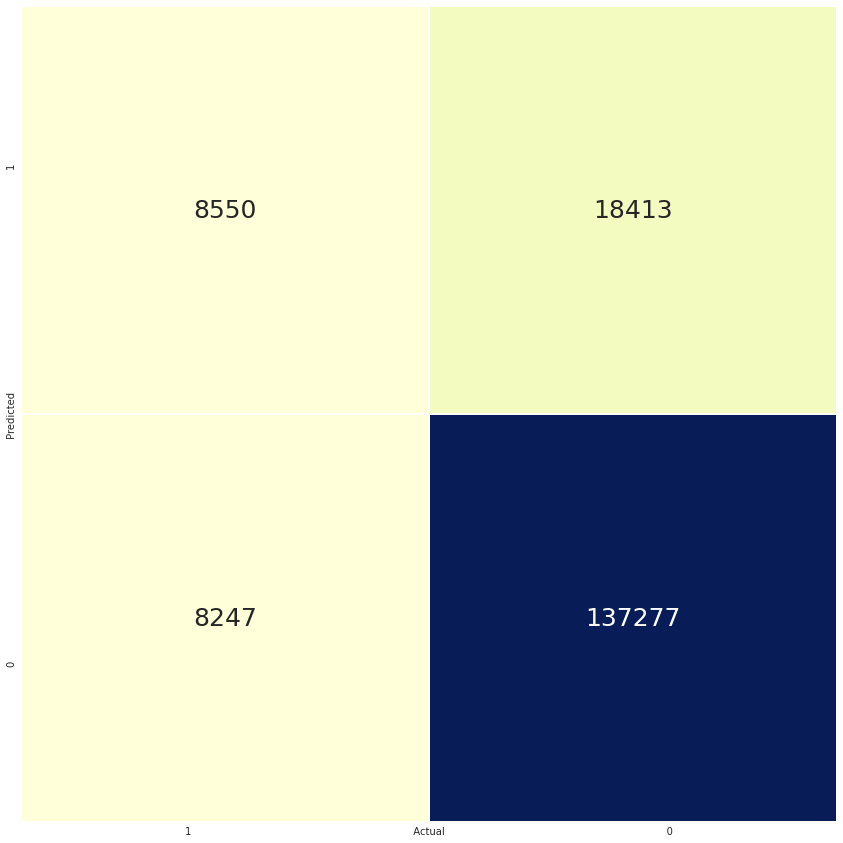

In [ ]:
cm = confusion_matrix(y_test,y_pred_)
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(15,15))
sns.heatmap([[tp,fp],[fn,tn]],
            annot=True,
            linewidths=.5,
            cmap="YlGnBu",
            square=True, 
            annot_kws={"fontsize":25},
            fmt='d',
            cbar=False)

plt.xticks([])
plt.xlabel('1                                                                       Actual                                                                       0')

plt.yticks([])
plt.ylabel('0                                                                       Predicted                                                                       1')



In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,y_pred_))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91    155690
           1       0.32      0.51      0.39     16797

    accuracy                           0.85    172487
   macro avg       0.63      0.70      0.65    172487
weighted avg       0.88      0.85      0.86    172487

